# CMPE 480 - Project 3

M. Akın Elden

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from heapq import heappush, heappop
from sklearn import datasets
iris_data = datasets.load_iris()

The data is reformatted for easier usage

In [ ]:
feature_reformat = lambda st : st.replace(' (cm)', '').replace(' ', '_')
feature_names = list(map(feature_reformat, iris_data.feature_names))
iris = pd.DataFrame(iris_data.data, columns=feature_names)
iris["target_class"] = iris_data.target

>**NOTE:** "Imp" means impurity for all the fields declared in the code

The Node class used to store the decision tree nodes. Each node contains train, validation and test data that fits to the current node. Each one also contains its left and right child nodes if the node is splitted.

In [ ]:
class Node:
    def __init__(self, trainImpurity, trainData, validationImpurity, validationData):
        # Train data stored in that node
        self.trainData = trainData
        # Stored train data's impurity value
        self.trainImp = trainImpurity
        grouped = trainData.groupby(["target_class"]).count().iloc[:,0]
        # Dominant class in the stored train data
        self.dominant_class = grouped.idxmax()
        self.validationImp = validationImpurity
        self.validationData = validationData
        self.leftChild = None
        self.rightChild = None
        self.hasChild = False
        # In which layer the node is splitted
        self.level = np.inf
        self.testData = None
        self.testImp = None

    def __lt__(self, other):
        # The node with higher impurity is prioritized in queue
        return self.trainImp > other.trainImp

    def assignLevel(self, level):
        self.level = level

    # Used to split the node and its data with given feature into the childs
    def split(self, feature, value, trainImpurities, validationImpurities):
        self.splitFeature = feature
        self.splitValue = value
        self.leftChild = Node(trainImpurities[0], self.trainData[self.trainData[feature]<=value], validationImpurities[0], self.validationData[self.validationData[feature]<=value])
        self.rightChild = Node(trainImpurities[1], self.trainData[self.trainData[feature]>value], validationImpurities[1], self.validationData[self.validationData[feature]>value])
        self.hasChild = True
        del self.trainData, self.validationData # for memory efficiency
        return self.leftChild, self.rightChild


In [ ]:
def entropy(data):
    n = len(data)
    probs = data.groupby(["target_class"]).count().iloc[:,0] / n
    return - np.sum(probs * np.log2(probs))

def informationGain(parentImpurity, childrenData):
    childEntropies = []
    childSizes = []
    for i in range(len(childrenData)):
        d = childrenData[i]
        childEntropies.append(entropy(d))
        childSizes.append(len(d))
    N = np.sum(childSizes)
    if N == 0: # no data given, no improvement
        return 0, childEntropies
    remainder = np.sum( np.array(childEntropies) * np.array(childSizes) / N )
    return parentImpurity - remainder, childEntropies

In [ ]:
def giniIndex(data):
    n = len(data)
    probs = data.groupby(["target_class"]).count().iloc[:,0] / n
    return 1 - np.sum(np.square(probs))

def giniGain(parentImpurity, childrenData):
    childGinis = []
    childSizes = []
    for i in range(len(childrenData)):
        d = childrenData[i]
        childGinis.append(giniIndex(d))
        childSizes.append(len(d))
    N = np.sum(childSizes)
    if N == 0: # no data given, no improvement
        return 0, childGinis
    remainder = np.sum( np.array(childGinis) * np.array(childSizes) / N )
    return parentImpurity - remainder, childGinis


The below function iterates all features and their unique values to determine the best split feature and value.

In [ ]:
def findBestSplit(data, parentImp, perfMeasure):
    bestFeature = ""
    bestValue = 0
    bestPerf = 0
    bestChildImps = []
    for c in data.columns[:-1]:
        currentData = data[[c, "target_class"]]
        uniques = currentData[c].unique()
        for v in uniques:
            leftChild = currentData[currentData[c] <= v]
            rightChild = currentData[currentData[c] > v]
            performance, childImps = perfMeasure(parentImp, [leftChild, rightChild])
            if performance > bestPerf:
                bestFeature = c
                bestValue = v
                bestPerf = performance
                bestChildImps = childImps
    return bestFeature, bestValue, bestPerf, bestChildImps

In [ ]:

def getImpurityMeasurementFunctions(impurityMeasureName):
    impMeasure = None
    perfMeasure = None
    if impurityMeasureName == "entropy":
        impMeasure = entropy
        perfMeasure = informationGain
    elif impurityMeasureName == "gini":
        impMeasure = giniIndex
        perfMeasure = giniGain
    else:
        raise Exception("Invalid impurity measurement")
    return impMeasure, perfMeasure

In [ ]:
def treeGrowth(train, validation, impurityMeasure="entropy"):
    # Impurity measurement functions are determined by parameter
    impMeasure, perfMeasure = getImpurityMeasurementFunctions(impurityMeasure)
    # Each created node is added to a priority queue and
    # the one with highest impurity is prioritized
    nodeQueue = []
    root = Node(impMeasure(train), train, impMeasure(validation), validation)
    heappush(nodeQueue, root)
    # Impurity measurements by each split is stored in list
    totalTrainImp = [impMeasure(train)]
    totalValidImp = [impMeasure(validation)]
    totalTrainRow = len(train)
    totalValidRow = len(validation)
    level = 0
    while(len(nodeQueue) > 0):
        currentNode = heappop(nodeQueue)
        if currentNode.trainImp == 0:
            break # all nodes are pure
        currentNode.assignLevel(level)
        feature, value, perf, childImps = findBestSplit(currentNode.trainData, currentNode.trainImp, perfMeasure)
        if perf <= 0:
            continue # no training performance improvement, don't split the node
        leftValidation = currentNode.validationData[currentNode.validationData[feature] <= value]
        rightValidation = currentNode.validationData[currentNode.validationData[feature] > value]
        validationPerf, childValImps = perfMeasure(currentNode.validationImp, [leftValidation, rightValidation])
        totalTrainImp.append(np.round( totalTrainImp[level] - perf * len(currentNode.trainData) / totalTrainRow , 5))
        totalValidImp.append( np.round( totalValidImp[level] - validationPerf * len(currentNode.validationData) / totalValidRow , 5)) 
        leftChild, rightChild = currentNode.split(feature, value, childImps, childValImps)
        heappush(nodeQueue, leftChild)
        heappush(nodeQueue, rightChild)
        level += 1
    return root, totalTrainImp, totalValidImp


In [ ]:
def predictTestData(test, root, split_number, impurityMeasure="entropy"):
    # Starting from the root, children are traversed until given number of split is reached
    impMeasure, perfMeasure = getImpurityMeasurementFunctions(impurityMeasure)
    totalTestRow = len(test)
    root.testData = test
    root.testImp = impMeasure(test)
    nodeQueue = []
    heappush(nodeQueue, (root.level, root))
    totalImpurities = [impMeasure(test)]
    leaves = [] # includes the leaf data of test and dominant class at that leaf (coming from training)
    while len(nodeQueue) > 0:
        currentNode = heappop(nodeQueue)[1]
        if currentNode.level >= split_number:
            if currentNode.testData is not None:
                leaves.append( (currentNode.testData, currentNode.dominant_class) )
            continue
        currentData = currentNode.testData
        leftData = currentData[currentData[currentNode.splitFeature] <= currentNode.splitValue]
        rightData = currentData[currentData[currentNode.splitFeature] > currentNode.splitValue]
        perf, childImps = perfMeasure(currentNode.testImp, [leftData, rightData])
        totalImpurities.append(np.round( totalImpurities[currentNode.level] - perf * len(currentNode.testData) / totalTestRow , 5))
        leftNode = currentNode.leftChild
        rightNode = currentNode.rightChild
        leftNode.testData = leftData
        leftNode.testImp = childImps[0]
        rightNode.testData = rightData
        rightNode.testImp = childImps[1]
        heappush(nodeQueue, (leftNode.level, leftNode) )
        heappush(nodeQueue, (rightNode.level, rightNode) )
    # Calculate the accuracy by calculating true estimates
    true_estimate = 0
    for l in leaves:
        # check if leaf data includes the predicted class
        if np.any(l[0]["target_class"] == l[1]):
            true_estimate += l[0].groupby(["target_class"]).count().loc[ l[1] ][0]
    accuracy = np.array((true_estimate, totalTestRow-true_estimate)).reshape((1,2))
    accuracy_table = pd.DataFrame(data=accuracy, columns=["True estimate","False estimate"], index=["Count"])
    return totalImpurities, accuracy_table

In [ ]:
def plotImpurityGraph(trainResults, validationResults, testResults, impurityMeasure):
    splits = np.arange(len(trainResults))
    plt.figure()
    plt.plot(splits, trainResults, 'k-', label='Training error')
    plt.plot(splits, validationResults, 'b-', label='Validation error')
    plt.plot(splits, testResults, 'g-', label='Test error')
    plt.xlabel("Number of splits")
    plt.xticks(splits, splits)
    if impurityMeasure == "entropy":
        plt.title("Loss with information gain")
        plt.ylabel("Total entropy")
    elif impurityMeasure == "gini":
        plt.title("Loss with gini impurity")
        plt.ylabel("Total gini")
    plt.legend()

In [ ]:
def decisionLearning(data, impurityMeasure="entropy", tr_val_te_ratios=[0.2, 0.4, 0.4], seed=480):
    np.random.seed(seed)
    shuffled = data.sample(frac=1)
    N = len(data)
    tr = int(N * tr_val_te_ratios[0])
    val = tr + int(N * tr_val_te_ratios[1])
    training = shuffled[:tr]
    validation = shuffled[tr:val]
    test = shuffled[val:]
    root, trainImps, validImps = treeGrowth(training, validation, impurityMeasure)
    # Get the max number of splits which gives the minimum validation error
    split_number = np.where(validImps == min(validImps))[0].max()
    testImps, accuracy = predictTestData(test, root, split_number, impurityMeasure)
    plotImpurityGraph(trainImps, validImps, testImps, impurityMeasure)
    return (root, trainImps, validImps, testImps, accuracy)

,True estimate,False estimate
Count,49,11


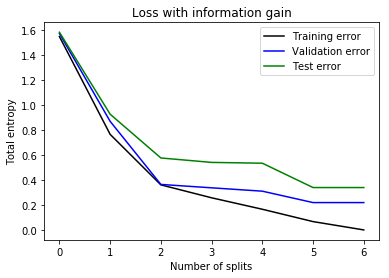

In [ ]:
results = decisionLearning(iris, seed=7)
results[-1]